### Install DeepTMpred and ESM

In [1]:
!git clone https://github.com/ISYSLAB-HUST/DeepTMpred.git
!pip install -r ./DeepTMpred/requirements.txt
!pip install fair-esm
import os
os.chdir('./DeepTMpred')
!sh ./script/download.sh

Cloning into 'DeepTMpred'...
remote: Enumerating objects: 110, done.
remote: Counting objects: 100% (110/110), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 110 (delta 49), reused 83 (delta 25), pack-reused 0
Receiving objects: 100% (110/110), 1.74 MiB | 6.67 MiB/s, done.
Resolving deltas: 100% (49/49), done.
     |████████████████████████████████| 2.3 MB 4.0 MB/s 
--2021-12-24 05:06:15--  https://zenodo.org/record/5163061/files/deepTMpred-b.pth
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 340701070 (325M) [application/octet-stream]
Saving to: ‘model_files/deepTMpred-b.pth’

deepTMpred-b.pth    100%[===================>] 324.92M  3.80MB/s    in 64s     

2021-12-24 05:07:21 (5.04 MB/s) - ‘model_files/deepTMpred-b.pth’ saved [340701070/340701070]

--2021-12-24 05:07:21--  https://zenodo.org/record/5163061/files/orientaion-b.pth
Resolv

### RUNNING

In [3]:
!python ./tmh_main.py /content/DeepTMpred/model_files/deepTMpred-b.pth /content/DeepTMpred/model_files/orientaion-b.pth ./notebook/test.fa

### TMH curve

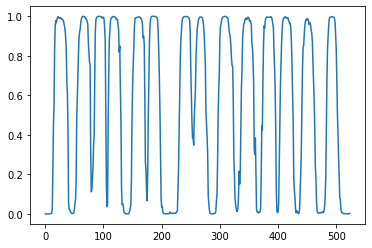

In [4]:
import json
import matplotlib.pyplot as plt
test = json.load(open('test.json'))
proba = test['test']['topo_proba']
plt.plot(proba)
